In [1]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob, os, copy
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'},
    'resnet50_ff2048': {
        'mrl0_nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/'
                  'deep-learning-base/checkpoints/imagenet1k/r50_mrl0_e0_ff2048.pt'},
    'resnet50_mrl': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints'\
                  '/imagenet1k/r50_mrl1_e0_ff2048.pt'
    },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
    },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
    }
}

In [3]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [4]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False})
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        FINETUNE_MODE, fraction, seed)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    gt, pred = out[2], out[0]
    return accuracy(gt, pred)

In [5]:
def results(model, source_dataset, FRACTIONS_OR_NUMBERS=None):
    plt_str = '== Finetuning results ==\n\n'
    model_to_frac_wise_test = {}
    for append in CHECKPOINT_PATHS[model].keys():
        plt_str += f'=== {model} - {append} ===\n\n'
        for ft_ds in FINETUNING_DATASETS:
            plt_str += f'==== {ft_ds} ====\n\n'
            frac_wise_val_accs, frac_wise_test_accs = {}, {}
            if FRACTIONS_OR_NUMBERS is None:
                FRACTIONS_OR_NUMBERS = sorted(
                    list(set(
                        [float(x.split('/frac-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                  f'{source_dataset}-ft-{ft_ds}/'
                                  f'*-bs-256-{append}') \
                         if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                            'full-feature' not in x and \
                            'layer' not in x and \
                            'pool' not in x]
                        )))
            for frac in FRACTIONS_OR_NUMBERS:
                if isinstance(frac, int):
                    actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
                else:
                    actual_fraction = frac
                PARTIAL_CHOICE_SEEDS = sorted(
                    list(set(
                        [int(x.split('-seed-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'frac-{actual_fraction:.5f}-*-bs-256-{append}') \
                        if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                           'full-feature' not in x and \
                           'layer' not in x and \
                           'pool' not in x]
                        )))
                for seed in PARTIAL_CHOICE_SEEDS:
                    model_path = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                           f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-{seed}-'
                                           f'ftmode-linear-lr-*-bs*-{append}/'
                                           '*-topk=1.ckpt') \
                                  if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                     'full-feature' not in x and \
                                     'layer' not in x and \
                                     'pool' not in x]
                    if len(model_path) == 0:
                        continue
                    model_path = model_path[0]
                    
                    pickled_preds = load_predictions(model_path)
                    if pickled_preds is not None:
                        test_acc = accuracy(pickled_preds['gt'], pickled_preds['pred']).item()
                    else:
                        test_acc = get_test_acc(model, source_dataset, ft_ds, 
                                                CHECKPOINT_PATHS[model][append], 
                                                model_path, seed, actual_fraction)
                    sd = torch.load(model_path)
                    val_acc = list(sd['callbacks'].values())[0]['best_model_score'].item()
                    if frac in frac_wise_val_accs:
                        frac_wise_val_accs[frac].append(val_acc)
                        frac_wise_test_accs[frac].append(test_acc)
                    else:
                        frac_wise_val_accs[frac] = [val_acc]
                        frac_wise_test_accs[frac] = [test_acc]
            
            model_to_frac_wise_test[f'{model}-{append}-{ft_ds}'] = copy.deepcopy(frac_wise_test_accs)
            
            full_acc_val = frac_wise_val_accs.pop(FRACTIONS_OR_NUMBERS[-1])
            full_acc_test = frac_wise_test_accs.pop(FRACTIONS_OR_NUMBERS[-1])
            x_vals, y_vals = list(zip(*sorted(frac_wise_val_accs.items(), key=lambda t: t[0])))
            _, y_tests = list(zip(*sorted(frac_wise_test_accs.items(), key=lambda t: t[0])))
            
            print (model, append, ft_ds)
            print (f'Full Acc: {full_acc_test}')
            for x, y in zip(x_vals, y_tests):
                print (f'For {x}, acc: {np.nanmean(y)} +/- {np.nanstd(y)}')
            print ()
            
            plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
                [[np.mean(_y) for _y in y_vals], [np.mean(_y) for _y in y_tests]], 
                'Fraction/number of neurons', 'Transfer Accuracy', ft_ds, 
                subfolder=source_dataset, filename=f'{model}_{ft_ds}_bs_{FINETUNE_BS}_{append}_{FINETUNE_MODE}', 
                extension='png', x_vals=x_vals, 
                legend_vals=['Val', 'Test', 'Full Layer (Val)', 'Full Layer (Test)'], 
                vertical_line=None, horizontal_lines=[np.mean(full_acc_val), np.mean(full_acc_test)], 
                horizontal_lines_err=[np.std(full_acc_val), np.std(full_acc_test)], 
                colors=[plt_hp.COLORS[0], plt_hp.COLORS[1], plt_hp.COLORS[0], plt_hp.COLORS[1]], 
                linestyles=['-', '-', ':', ':'], y_lims=(0.,1.), root_dir='.', 
                paper_friendly_plots=False, plot_inside=False, legend_location='best', 
                savefig=True, figsize=(10,6), marker=[True, True, False, False], 
                results_subfolder_name='transfer_analysis', grid_spacing=None, 
                y_err=[[np.std(_y) for _y in y_vals], [np.std(_y) for _y in y_tests]], 
                legend_ncol=None), SERVER_PROJECT_PATH, size=700))
            print (ft_ds, frac_wise_val_accs)
    with open(f'./results/transfer_analysis/{source_dataset}/'
              f'wiki_results-{model}-{FINETUNE_MODE}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'transfer_analysis', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return model_to_frac_wise_test

resnet50 nonrob cifar10
Full Acc: [0.8913999795913696]
For 0.0005, acc: 0.1229200005531311 +/- 0.01794462807466834
For 0.001, acc: 0.15139999836683274 +/- 0.024089417611329694
For 0.002, acc: 0.18558000028133392 +/- 0.0235813834808322
For 0.003, acc: 0.23235999643802643 +/- 0.02127069327612794
For 0.004, acc: 0.2521800011396408 +/- 0.025304820043298842
For 0.005, acc: 0.2738999992609024 +/- 0.017290227169671407
For 0.01, acc: 0.3705000042915344 +/- 0.020683430479357803
For 0.05, acc: 0.694760000705719 +/- 0.02136254011838285
For 0.1, acc: 0.778879988193512 +/- 0.011917944145571398
For 0.2, acc: 0.832260000705719 +/- 0.007159500547376095
For 0.3, acc: 0.8519200086593628 +/- 0.004837934344853527
For 0.5, acc: 0.8740199923515319 +/- 0.0035419643114184066
For 0.8, acc: 0.8878000020980835 +/- 0.0032637349839890243
For 0.9, acc: 0.8911400079727173 +/- 0.0030643770234324145

[(0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0

../plot_helper.py:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


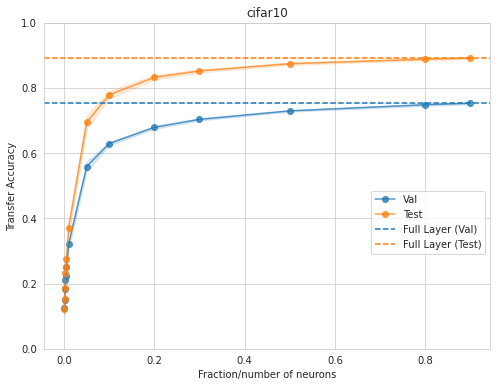

cifar10 {0.0005: [0.11954693496227264, 0.1268082857131958, 0.10528450459241867, 0.15935033559799194, 0.10957659035921097], 0.001: [0.13647064566612244, 0.14354825019836426, 0.1489540934562683, 0.18858127295970917, 0.13692888617515564], 0.002: [0.16791069507598877, 0.1790148913860321, 0.18389734625816345, 0.22588862478733063, 0.15446901321411133], 0.003: [0.1794070303440094, 0.20845501124858856, 0.2117285281419754, 0.24285539984703064, 0.21290403604507446], 0.004: [0.19186079502105713, 0.21354931592941284, 0.23167705535888672, 0.24655352532863617, 0.23498733341693878], 0.005: [0.21204370260238647, 0.24017570912837982, 0.25564491748809814, 0.2823238670825958, 0.2561633288860321], 0.01: [0.326407253742218, 0.30084556341171265, 0.3226470947265625, 0.3400266170501709, 0.3112342357635498], 0.05: [0.5496917963027954, 0.5356155633926392, 0.5591580271720886, 0.5696066617965698, 0.5800833702087402], 0.1: [0.62376868724823, 0.6221764087677002, 0.6302324533462524, 0.6372469663619995, 0.63279342651

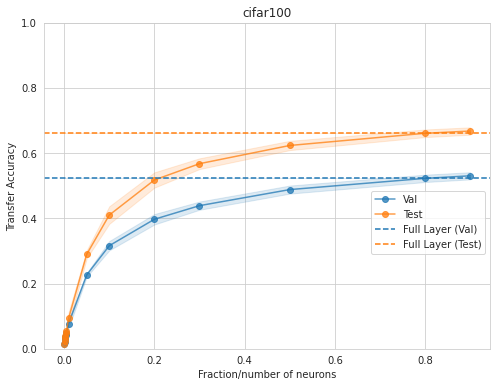

cifar100 {0.0005: [0.011769605800509453, 0.017835237085819244, 0.01143419835716486, 0.018128283321857452, 0.013110650703310966], 0.001: [0.014627351425588131, 0.022320307791233063, 0.018467091023921967, 0.026473356410861015, 0.018967680633068085], 0.002: [0.027539480477571487, 0.032077398151159286, 0.026562687009572983, 0.04096005856990814, 0.025316813960671425], 0.003: [0.029130998998880386, 0.036612048745155334, 0.03368097171187401, 0.04816265404224396, 0.03075265884399414], 0.004: [0.03260248154401779, 0.043986983597278595, 0.03793006390333176, 0.05327843502163887, 0.036494918167591095], 0.005: [0.03846795856952667, 0.04423993453383446, 0.040224384516477585, 0.06886019557714462, 0.04305508732795715], 0.01: [0.07263638079166412, 0.08295067399740219, 0.07469453662633896, 0.09865100681781769, 0.05844549089670181], 0.05: [0.22275617718696594, 0.21779648959636688, 0.22896748781204224, 0.2338716834783554, 0.22906461358070374], 0.1: [0.3014412522315979, 0.3063242435455322, 0.32929286360740

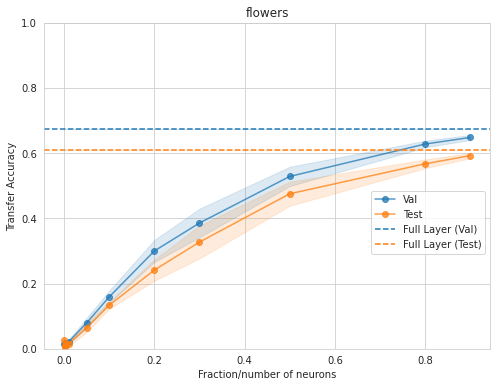

flowers {0.0005: [0.016190174967050552, 0.010803703218698502, 0.018608514219522476, 0.015186700969934464, 0.011768731288611889], 0.001: [0.011303518898785114, 0.012272391468286514, 0.011307363398373127, 0.010311576537787914, 0.011780265718698502], 0.002: [0.01572880893945694, 0.012283925898373127, 0.008839043788611889, 0.012283924967050552, 0.014725332148373127], 0.003: [0.010769100859761238, 0.02007720246911049, 0.017628107219934464, 0.013706477358937263, 0.02006566897034645], 0.004: [0.0161747969686985, 0.013225886039435863, 0.027428336441516876, 0.020584706217050552, 0.0191044844686985], 0.005: [0.025990404188632965, 0.016163263469934464, 0.018635425716638565, 0.015690360218286514, 0.014706108719110489], 0.01: [0.011265071108937263, 0.022510919719934464, 0.020115649327635765, 0.020588552579283714, 0.03185746818780899], 0.05: [0.07545290887355804, 0.10390779376029968, 0.07938607037067413, 0.056394562125205994, 0.0842919573187828], 0.1: [0.17691545188426971, 0.18575064837932587, 0.149

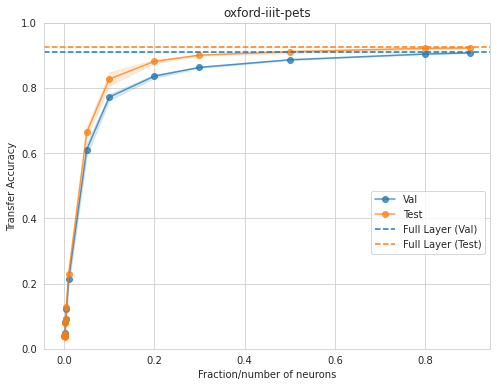

oxford-iiit-pets {0.0005: [0.03469768911600113, 0.058588091284036636, 0.03629273921251297, 0.0309605710208416, 0.04168223589658737], 0.001: [0.030226025730371475, 0.055158089846372604, 0.039285410195589066, 0.03873626887798309, 0.03450449928641319], 0.002: [0.028879359364509583, 0.0738663375377655, 0.05397772043943405, 0.047850146889686584, 0.041157156229019165], 0.003: [0.0827813595533371, 0.10337692499160767, 0.06356431543827057, 0.06623782962560654, 0.09170912951231003], 0.004: [0.07443670928478241, 0.12382034212350845, 0.08565443754196167, 0.08386194705963135, 0.09312938898801804], 0.005: [0.12067269533872604, 0.146384596824646, 0.13172341883182526, 0.10493730008602142, 0.10999277979135513], 0.01: [0.2339957058429718, 0.22673234343528748, 0.2207576036453247, 0.19179333746433258, 0.19447535276412964], 0.05: [0.6108617782592773, 0.6254861354827881, 0.6365283727645874, 0.5820227861404419, 0.5974722504615784], 0.1: [0.7790336608886719, 0.7696975469589233, 0.7826730608940125, 0.77029973

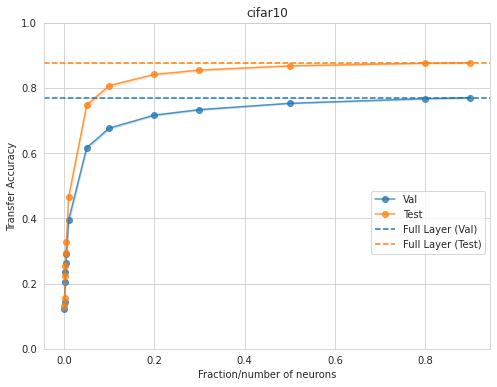

cifar10 {0.0005: [0.1265285313129425, 0.11961649358272552, 0.1151275485754013, 0.13065218925476074, 0.11731739342212677], 0.001: [0.14361095428466797, 0.13518540561199188, 0.156280517578125, 0.14698590338230133, 0.13695184886455536], 0.002: [0.2291000336408615, 0.1645336002111435, 0.19693802297115326, 0.23509949445724487, 0.2049006223678589], 0.003: [0.2579345703125, 0.2001740038394928, 0.2335602045059204, 0.252212256193161, 0.23135867714881897], 0.004: [0.2836717963218689, 0.24395880103111267, 0.255433589220047, 0.2808268666267395, 0.25767335295677185], 0.005: [0.2949533462524414, 0.27139902114868164, 0.28784245252609253, 0.30811557173728943, 0.2951526343822479], 0.01: [0.3885359764099121, 0.37577682733535767, 0.3989194631576538, 0.4053497612476349, 0.40417253971099854], 0.05: [0.6182283163070679, 0.6137151718139648, 0.6077014803886414, 0.6191455125808716, 0.6226739883422852], 0.1: [0.6775320172309875, 0.6780551075935364, 0.6724922060966492, 0.6817494630813599, 0.6792911291122437, 0.6

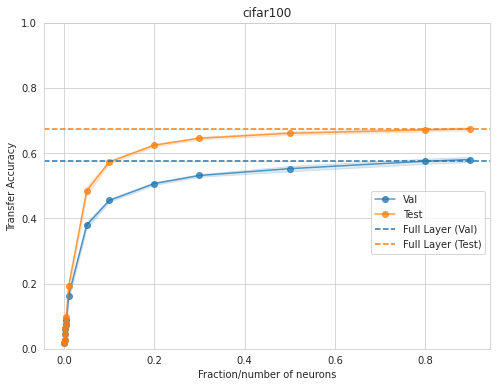

cifar100 {0.0005: [0.016172125935554504, 0.015453372150659561, 0.021434810012578964, 0.01907464489340782, 0.017599835991859436], 0.001: [0.020859677344560623, 0.02661735564470291, 0.03304462507367134, 0.026639217510819435, 0.02727842517197132], 0.002: [0.03521612286567688, 0.042476702481508255, 0.04738454148173332, 0.049077313393354416, 0.046986792236566544], 0.003: [0.051436617970466614, 0.05589158833026886, 0.0636361837387085, 0.0619710348546505, 0.06523634493350983], 0.004: [0.06971809267997742, 0.06995562463998795, 0.07715532928705215, 0.07675851136445999], 0.005: [0.08689111471176147, 0.086604043841362, 0.09456060081720352, 0.09051456302404404], 0.01: [0.1501409113407135, 0.15524908900260925, 0.17078223824501038, 0.17518557608127594], 0.05: [0.37309718132019043, 0.36608925461769104, 0.3917955160140991, 0.3857804834842682], 0.1: [0.44078660011291504, 0.44210606813430786, 0.457633912563324, 0.4577689468860626, 0.45761507749557495, 0.4577135145664215, 0.4566030204296112, 0.4548237025

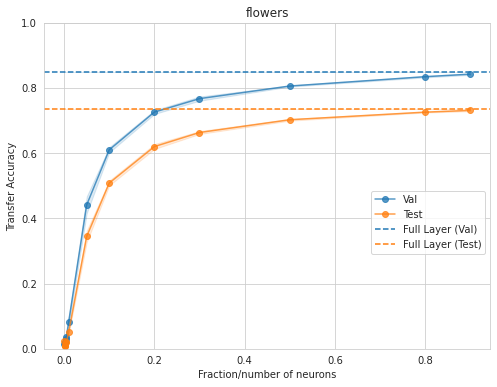

flowers {0.0005: [0.009830985218286514, 0.01665923371911049, 0.014221671968698502, 0.013718011789023876, 0.015674980357289314], 0.001: [0.013698788359761238, 0.012257013469934464, 0.014187069609761238, 0.015205923467874527, 0.018604669719934464], 0.002: [0.014221671968698502, 0.01963505893945694, 0.017185963690280914, 0.017616571858525276, 0.012756828218698502], 0.003: [0.017612727358937263, 0.022510919719934464, 0.021061453968286514, 0.022038016468286514, 0.026432547718286514], 0.004: [0.0274360254406929, 0.03771299868822098, 0.028950847685337067, 0.024483267217874527, 0.03869340568780899], 0.005: [0.03526005893945694, 0.03529081493616104, 0.046559736132621765, 0.019573543220758438, 0.043583907186985016], 0.01: [0.0711045116186142, 0.08043568581342697, 0.0759565681219101, 0.07838644087314606, 0.10443836450576782], 0.05: [0.4238819479942322, 0.4023206830024719, 0.4704263210296631, 0.46700066328048706, 0.44304412603378296], 0.1: [0.5974985957145691, 0.6043345332145691, 0.613073587417602

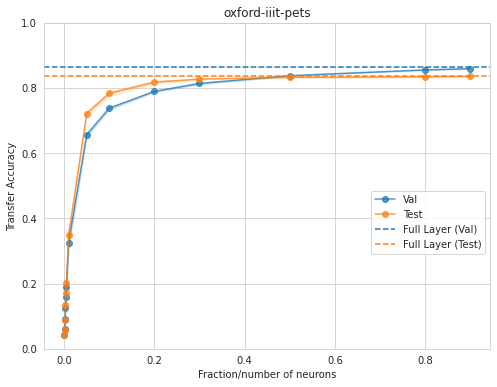

oxford-iiit-pets {0.0005: [0.045089587569236755, 0.04245499521493912, 0.038943614810705185, 0.04593948274850845, 0.04573001340031624], 0.001: [0.06291751563549042, 0.061183761805295944, 0.05006156116724014, 0.06931541860103607, 0.056850798428058624], 0.002: [0.09594443440437317, 0.08386974036693573, 0.09413142502307892, 0.09558424353599548, 0.08995909988880157], 0.003: [0.13256269693374634, 0.13077020645141602, 0.12537223100662231, 0.13186636567115784, 0.11023904383182526], 0.004: [0.14109840989112854, 0.17126712203025818, 0.15814226865768433, 0.1646314561367035, 0.15563787519931793], 0.005: [0.18685957789421082, 0.19816789031028748, 0.18949416279792786, 0.19604915380477905, 0.17546138167381287], 0.01: [0.3124738335609436, 0.33825719356536865, 0.33414924144744873, 0.2920806407928467, 0.35142308473587036], 0.05: [0.6637383699417114, 0.6440904140472412, 0.6644255518913269, 0.6538354754447937, 0.6536514759063721], 0.1: [0.7291228175163269, 0.7418556213378906, 0.7418534755706787, 0.7379267

In [6]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
FINETUNE_MODE = 'random'
resnet50_to_fracwise_accs = results(MODEL, SOURCE_DATASET)

[True, True, True, True]
[(0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9)] [[0.1229200005531311, 0.15139999836683274, 0.18558000028133392, 0.23235999643802643, 0.2521800011396408, 0.2738999992609024, 0.3705000042915344, 0.694760000705719, 0.778879988193512, 0.832260000705719, 0.8519200086593628, 0.8740199923515319, 0.8878000020980835, 0.8911400079727173], [0.014640000090003014, 0.022420000284910202, 0.03343999981880188, 0.04003999978303909, 0.047860000282526016, 0.053920000046491626, 0.09385999888181687, 0.28966000080108645, 0.4099999964237213, 0.5175599932670594, 0.5675599932670593, 0.6233800053596497, 0.6607599973678588, 0.6676399827003479], [0.026573426276445388, 0.00621239235624671, 0.008

../plot_helper.py:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


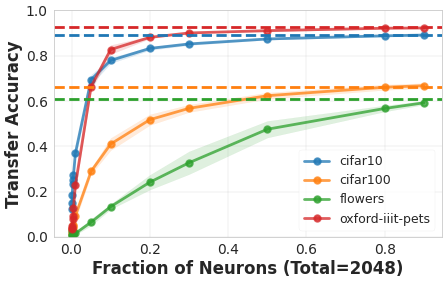

[True, True, True, True]
[(0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9), (0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9)] [[0.1314400002360344, 0.156980000436306, 0.2222400039434433, 0.25476000308990476, 0.2949400007724762, 0.32829999923706055, 0.4647800028324127, 0.7464800000190734, 0.806580001115799, 0.8412400046984355, 0.8542899986108144, 0.8674600005149842, 0.8755199909210205, 0.8769400119781494], [0.01801999993622303, 0.026900000125169753, 0.0446600005030632, 0.06223999932408333, 0.07782499957829714, 0.09689999930560589, 0.19107500091195107, 0.4841750040650368, 0.5728344876190712, 0.6242428634847913, 0.6456148116676895, 0.660974994301796, 0.6710000038146973, 0.6745000034570694], [0.022995609045028686, 0.009269799944013358, 0.00907464

../plot_helper.py:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


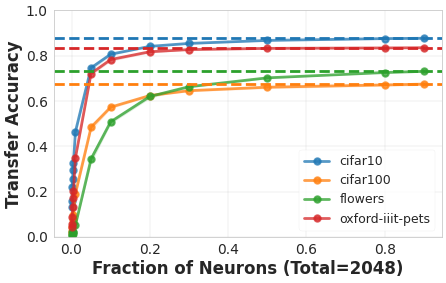

In [7]:
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals, all_full_accs = [], [], []
    for ft_ds in FINETUNING_DATASETS:
        x, y = list(zip(*sorted(
            resnet50_to_fracwise_accs[f'resnet50-{append}-{ft_ds}'].items(), key=lambda i:i[0])))
        all_full_accs.append(y[-1])
        all_x_vals.append(x[:-1])
        all_y_vals.append(y[:-1])
    all_y_means = [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals]
    print ([len(all_y_means[i]) == len(all_x_vals[i]) for i in range(len(all_x_vals))])
    plt_hp.line_plot(
        [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'Transfer Accuracy', '', 
        subfolder=SOURCE_DATASET, filename=f'{MODEL}_allds_bs_{FINETUNE_BS}_{append}_{FINETUNE_MODE}', 
        extension='png', x_vals=all_x_vals, legend_vals=FINETUNING_DATASETS, vertical_line=None, 
        horizontal_lines=[np.mean(full_acc) for full_acc in all_full_accs], 
        horizontal_lines_err=[np.std(full_acc) for full_acc in all_full_accs], 
        colors=plt_hp.COLORS[:len(FINETUNING_DATASETS)] * 2, 
        linestyles=['-']*len(FINETUNING_DATASETS) + [':']*len(FINETUNING_DATASETS), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=[True] * len(FINETUNING_DATASETS) + [False] * len(FINETUNING_DATASETS), 
        results_subfolder_name='transfer_analysis', grid_spacing=None, 
        y_err=[[np.std(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([37]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([168]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([106]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([250]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([227]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([266]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([303]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([195]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'neuron_indices': tensor([382]), 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=10, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113]), 'in_features': 19, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=10, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243]), 'in_features': 38, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=10, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311]), 'in_features': 76, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 33

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 36

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 16

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 18

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 13

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  4

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  4

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=10, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311, 181, 370, 240, 335,  25, 361, 230, 321,
        244,  44,  23, 252, 317, 156, 166, 36

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 33

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 36

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 16

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 18

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 13

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  4

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  4

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=10, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=384, out_features=10, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 36

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

vit_small_patch16_224 nonrob cifar10
Full Acc: [tensor(0.9594)]
For 0.005, acc: 0.15880000591278076 +/- 0.02691228687763214
For 0.05, acc: 0.6252332925796509 +/- 0.045580457895994186
For 0.1, acc: 0.7992110848426819 +/- 0.02383742853999138
For 0.2, acc: 0.9039332866668701 +/- 0.00720908772200346
For 0.5, acc: 0.9489889144897461 +/- 0.0013477855827659369
For 0.9, acc: 0.9592000246047974 +/- 0.0006383570143952966



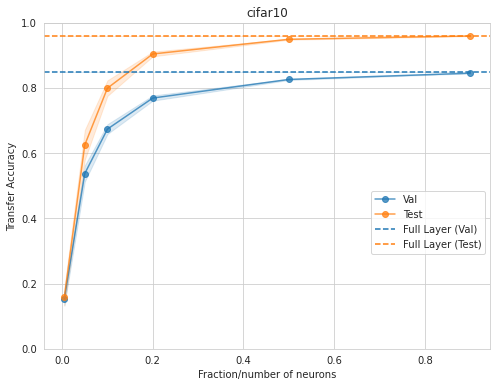

Global seed set to 2


cifar10 {0.005: [0.13393419981002808, 0.1511659175157547, 0.19491812586784363, 0.16913139820098877, 0.1611577570438385, 0.14463262259960175, 0.12440050393342972, 0.16311556100845337, 0.14004497230052948], 0.05: [0.5269739031791687, 0.5201565027236938, 0.534585177898407, 0.4995632469654083, 0.5397205352783203, 0.5548776388168335, 0.5351396203041077, 0.5299835205078125, 0.594994306564331], 0.1: [0.6611281037330627, 0.6401970386505127, 0.6841609477996826, 0.6717435717582703, 0.6750726103782654, 0.6822006702423096, 0.6891412138938904, 0.6689534783363342, 0.6903959512710571], 0.2: [0.7663167119026184, 0.7521983981132507, 0.7682449221611023, 0.765108048915863, 0.7666423320770264, 0.7807142734527588, 0.767365574836731, 0.7745798826217651, 0.7780823707580566], 0.5: [0.8242071866989136, 0.82564777135849, 0.8246984481811523, 0.8226430416107178, 0.8261197209358215, 0.8274852633476257, 0.8263039588928223, 0.8280870914459229, 0.8273830413818359], 0.9: [0.8449890613555908, 0.8461380004882812, 0.8443

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([37]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([168]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([106]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([250]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([227]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([266]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([303]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([195]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'neuron_indices': tensor([382]), 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=100, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113]), 'in_features': 19, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=100, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243]), 'in_features': 38, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=100, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311]), 'in_features': 76, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=100, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311, 181, 370, 240, 335,  25, 361, 230, 321,
        244,  44,  23, 252, 317, 156, 166, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=100, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311, 181, 370, 240, 335,  25, 361, 230, 321,
        244,  44,  23, 252, 317, 156, 166, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=384, out_features=100, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

vit_small_patch16_224 nonrob cifar100
Full Acc: [tensor(0.8341)]
For 0.005, acc: 0.018655555322766304 +/- 0.002080657286569476
For 0.05, acc: 0.35324445366859436 +/- 0.017573157325387
For 0.1, acc: 0.5743222832679749 +/- 0.011477882973849773
For 0.2, acc: 0.729722261428833 +/- 0.004039462190121412
For 0.5, acc: 0.8159555792808533 +/- 0.0027669186238199472
For 0.9, acc: 0.8331333994865417 +/- 0.0017036041244864464



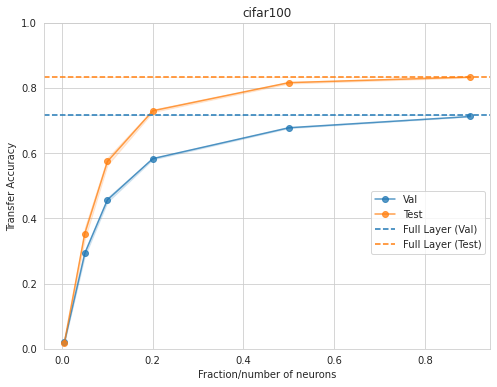

Global seed set to 2


cifar100 {0.005: [0.018499914556741714, 0.019398212432861328, 0.02171565592288971, 0.020727086812257767, 0.01883375085890293, 0.01911919377744198, 0.021536286920309067, 0.01894460804760456, 0.021907920017838478], 0.05: [0.296118825674057, 0.29334405064582825, 0.29617172479629517, 0.2937215566635132, 0.2928699851036072, 0.28690457344055176, 0.2880663573741913, 0.27346301078796387, 0.3107902407646179], 0.1: [0.44812706112861633, 0.44966912269592285, 0.4732383191585541, 0.4573644697666168, 0.45493486523628235, 0.4516955614089966, 0.46125274896621704, 0.4550190269947052, 0.45969295501708984], 0.2: [0.5849478840827942, 0.5796098113059998, 0.5803442597389221, 0.5820179581642151, 0.5812788605690002, 0.583044171333313, 0.5837314128875732, 0.5889527201652527, 0.5834277272224426], 0.5: [0.6759592890739441, 0.6785129308700562, 0.6783524751663208, 0.6748153567314148, 0.6773369312286377, 0.6786138415336609, 0.6775789856910706, 0.678673267364502, 0.6803520917892456], 0.9: [0.712035596370697, 0.71284

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([37]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([168]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([106]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([250]), 'in_features': 1, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([227]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([266]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([303]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([195]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([382]), 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'neuron_indices': tensor([137]), 'in_features': 1, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269]), 'in_features': 19, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=102, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172]), 'in_features': 19, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61]), 'in_features': 38, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124]), 'in_features': 38, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=102, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172,  10, 260, 339, 208,  31, 263, 262, 258, 343,
        275,  24, 164,  94,  40, 269,  42, 246, 307,   9]), 'in_features': 38, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197]), 'in_features': 76, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7]), 'in_features': 76, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=76, out_features=102, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172,  10, 260, 339, 208,  31, 263, 262, 258, 343,
        275,  24, 164,  94,  40, 269,  42, 246, 307,   9, 155, 122, 109, 379,
         55, 211, 153,  71,  22,  12, 302, 243, 256, 277,  38,  57,  96,  59,
         66, 305, 285,  61,  28, 317, 202, 265, 348,  45, 118, 297, 231, 147,
        224, 191, 295,  33,   7, 157]), 'in_features': 76, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 3

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311, 181, 370, 240, 335,  25, 361, 230, 321,
        244,  44,  23, 252, 317, 156, 166, 3

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=192, out_features=102, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172,  10, 260, 339, 208,  31, 263, 262, 258, 343,
        275,  24, 164,  94,  40, 269,  42, 246, 307,   9, 155, 122, 109, 379,
         55, 211, 153,  71,  22,  12, 302, 243, 256, 277,  38,  57,  96,  59,
         66, 305, 285,  61,  28, 317, 202, 265, 348,  45, 118, 297, 231, 147,
        224, 191, 295,  33,   7, 157,  23, 357, 309, 158,  53, 363, 274, 141,
        360,  48,  49, 355, 223, 125, 126, 2

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61, 172,  89,  11, 196,
        227, 366,   4, 291,  96,  48, 257, 298, 140, 306,  56, 363,  75, 209,
        255, 122,  45, 217,  28, 326, 111, 116,  14, 107, 325, 102, 216, 112,
         42, 375, 188, 128,  86, 315, 249, 316,   5, 339, 175,   2, 352, 301,
        259, 346, 205,  60, 378, 238, 266, 3

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254, 136, 315, 253, 204,
         74, 356, 218, 321, 378, 102, 273, 380, 293, 208, 157, 290,   4,  19,
        277, 346,  82, 221, 244, 180, 278, 312, 128, 141,  49, 310, 327, 274,
        194,  88, 287,  21, 371, 212,  45, 259, 133, 134, 181, 366,  47, 152,
        296,  87, 313,  14, 360, 269,  32, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45, 339, 243, 144, 193,
        158,  75,  16,  98, 188,  99, 170, 166, 261, 207, 214, 138, 310, 143,
        186, 199, 121, 296, 167,  29,  30, 284, 337, 137,  83, 156, 109, 101,
        270, 373, 103, 291, 350, 286, 107, 190, 122,  25, 215,  11, 244, 316,
        223, 153, 340, 348, 281, 334,  44, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327, 331, 343,  54, 371,
        240, 263, 104,  38, 127, 151,  14,  59,  92,   7, 148, 196, 173, 124,
        311, 350,  55,  40, 225, 176,  47, 290, 369, 313,   3, 272, 376, 216,
        118,  63, 379, 107, 211,  17,  97, 332,  15, 178, 366, 302, 355, 374,
        193,  72, 303, 258, 182, 288,  11, 1

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124, 311, 242, 156, 105,
        172, 120, 206, 281, 382, 271, 195, 303, 154,  97,   6, 223, 297,  54,
         22, 268, 217, 259, 113,  31,  43,  10,  16, 236, 161, 175, 339, 220,
         94, 190, 214, 249, 225, 196, 136, 169,  88, 198, 135, 346, 291, 122,
        265, 130, 238, 374, 257, 193, 173,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247,  69, 299,  30, 370,
        366, 310,  96,  41, 206, 258, 164, 131, 159, 125, 231,   6, 264, 222,
        176, 382, 140,  91, 154, 117, 245, 107, 284, 227,  67, 347, 350, 173,
        139, 112, 293,  93, 241,   7, 375, 263, 251, 182, 163, 283, 277, 365,
        195,  48,  34,  77,   1,  32, 237,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83, 174, 346,  82, 359,
        250, 122, 105,  64, 130, 114, 347, 191, 360,  99, 207, 284, 128, 131,
         18, 246,  79, 243, 112, 209, 217, 173, 266, 189, 123,  45, 290,  38,
        291, 230, 212, 265, 132,  15,  75, 186, 181, 192, 277, 228, 208, 272,
        378,  98, 136, 165,  43, 251, 129,  

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243, 111,  41, 187,  29,
        205, 285, 198, 250,  65,  22, 280, 101, 123, 231,  21, 210, 336, 241,
        117, 360,  15,  13, 102, 375, 118, 116, 232, 299, 263, 176, 292, 268,
         98, 217, 168,  97, 124, 311, 181, 370, 240, 335,  25, 361, 230, 321,
        244,  44,  23, 252, 317, 156, 166, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=345, out_features=102, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172,  10, 260, 339, 208,  31, 263, 262, 258, 343,
        275,  24, 164,  94,  40, 269,  42, 246, 307,   9, 155, 122, 109, 379,
         55, 211, 153,  71,  22,  12, 302, 243, 256, 277,  38,  57,  96,  59,
         66, 305, 285,  61,  28, 317, 202, 265, 348,  45, 118, 297, 231, 147,
        224, 191, 295,  33,   7, 157,  23, 357, 309, 158,  53, 363, 274, 141,
        360,  48,  49, 355, 223, 125, 126, 2

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=384, out_features=102, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150, 101, 359, 172, 298,
        376, 322,  24, 259, 313, 183, 128,  11, 194, 158,  10, 278, 282,  35,
        167,  21, 241, 306, 234,  19, 198, 379,  23,  31, 137, 240,  84, 106,
        211,  25, 176, 267, 141, 197, 129, 177, 188, 133,  22, 175, 371, 160,
        147, 138, 178,  56,   0, 347, 248, 3

Predicting: 0it [00:00, ?it/s]

vit_small_patch16_224 nonrob flowers
Full Acc: [tensor(0.9933)]
For 0.005, acc: 0.02026345767080784 +/- 0.004855040460824966
For 0.05, acc: 0.8591965436935425 +/- 0.020248696208000183
For 0.1, acc: 0.9613596200942993 +/- 0.004093064460903406
For 0.2, acc: 0.9831191897392273 +/- 0.003013491164892912
For 0.5, acc: 0.9912668466567993 +/- 0.001103110727854073
For 0.9, acc: 0.9928606152534485 +/- 0.0010089417919516563



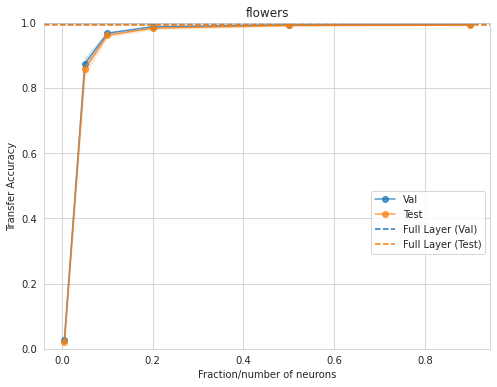

Global seed set to 2


flowers {0.005: [0.026017317548394203, 0.03384903818368912, 0.03034648858010769, 0.026447925716638565, 0.02690972201526165, 0.0289015993475914, 0.02747550792992115, 0.02402653731405735, 0.02936662919819355, 0.02983940951526165], 0.05: [0.8716127872467041, 0.8285287022590637, 0.8745771050453186, 0.8652228713035583, 0.8686600923538208, 0.8735274076461792, 0.8871992826461792, 0.8783947229385376, 0.8974376916885376, 0.894569993019104], 0.1: [0.9706070423126221, 0.9642208814620972, 0.9627599120140076, 0.96375572681427, 0.9700676202774048, 0.9622163772583008, 0.9730825424194336, 0.9652235507965088, 0.9735475778579712, 0.9701141119003296], 0.2: [0.9833446145057678, 0.9862819910049438, 0.9843250513076782, 0.9887233972549438, 0.9906684160232544, 0.9872194528579712, 0.9897305965423584, 0.9872504472732544, 0.989219069480896, 0.9882502555847168], 0.5: [0.993148684501648, 0.9936254024505615, 0.9931448698043823, 0.9921605587005615, 0.9921565055847168, 0.9946134090423584, 0.9921410083770752, 0.992156

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([37]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([168]), 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([106]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([250]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([227]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([266]), 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([303]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([195]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([382]), 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'neuron_indices': tensor([137]), 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26]), 'in_features': 19, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334]), 'in_features': 19, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113]), 'in_features': 19, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=19, out_features=37, bias=True))]), 'neuron_indices': tensor([137, 293, 312, 358, 376,  78, 311, 273, 241, 189, 176, 345, 301, 213,
        200,  29, 240, 354, 172]), 'in_features': 19, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([ 37,  88, 258, 104, 307, 131, 251, 113,  31,  66, 162, 117, 364, 158,
        277,  69, 198, 329, 194,  50, 142,  84, 166, 340, 147,  77,  92, 176,
         49, 153,  38,  73,  87,  57,  71,  16, 359,  61]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([168,   9,  67, 159,  62, 235,  96, 153,  72, 270,  32, 122, 215, 213,
        249, 269, 287,  81, 368,  89,   8, 309,  49, 250, 115, 329, 356, 231,
        195,  82, 341,  63, 330,  47, 350, 187, 191, 150]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([106, 302, 345, 306,  44,  25, 246, 165, 173, 373,  62, 354,  89,  61,
        170, 154, 119, 223,  26, 158,  96,  50, 333, 210,  20,  13,  51,  60,
        150, 174,  42, 362, 252, 379, 303,  66,   8, 254]), 'in_features': 38, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([250, 172, 245, 263,  73,  12, 239,   0, 234, 120, 266, 204,  47, 302,
        364, 328,  71, 145, 336,  61, 118, 155, 212, 194, 146, 301, 139,   2,
         95,  19,  93, 299, 326, 111, 298, 277, 106,  45]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([227, 245, 139,   9, 250,  75,  70, 239,  80, 163, 325,  83,  95, 365,
        112,   5, 119, 155, 269, 323, 149, 138,  90,  33,  68, 381, 279, 135,
        183, 335, 126, 125, 349, 162,  64,  81, 157, 327]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 6
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([266, 315, 283, 323, 218, 318, 215, 111,  48, 192, 187, 174,  67, 213,
        351, 344, 319, 324, 334, 188, 264,  66, 178, 316,  76, 248, 191, 309,
         62, 276,   7, 232, 143, 342,  86, 340, 287, 124]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 7
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([303, 204, 193, 254,  87, 153, 257, 298, 132,  20, 184, 156, 368, 175,
        376, 208,  42, 190, 309,  47, 260, 115,   2, 122, 292, 315, 359,  37,
        342,  57, 219, 129, 108, 142, 239, 196, 180, 247]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([195, 178, 363, 219, 321,  52, 274, 351, 280, 295, 150, 118, 205, 257,
        211, 172, 330, 256, 332, 309, 153, 158, 329, 267, 306,  74, 354, 188,
        342,  58, 180,   4, 115, 223,  39,  24, 235,  83]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 9
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=38, out_features=37, bias=True))]), 'neuron_indices': tensor([382, 379, 274, 284, 106,  74, 247,  48, 197, 110, 142, 342, 279,  24,
        130,  86,  88, 301, 113, 140, 137, 369, 254, 343, 310, 174, 282, 258,
        216, 209, 146,   0,  92, 129, 294,  40, 126, 243]), 'in_features': 38, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch16_224'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

In [ ]:
SOURCE_DATASET = 'imagenet21k'
MODEL = 'vit_small_patch32_224'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50_mrl'
FINETUNE_MODE = 'first'
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
results(MODEL, SOURCE_DATASET, NUMBERS)

In [ ]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50_mrl'
FINETUNE_MODE = 'random'
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
results(MODEL, SOURCE_DATASET, NUMBERS)